In [971]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.dates as mdates
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

unidf=pd.read_csv(r"C:\Users\hajar\Time-Series-Crime-Forecasting-Minneapolis-3\data\Univ_Date.csv")

## ARIMA
1. Split the data into a train and test using time-based splitting
2. Check Assumptions and make corrections if needed
3. Select ARIMA Model
4. Select Best ARIMA Model
4. Interpret

### Split Data

Partition the data set into 4 parts corresponding to 2019-2024. then create nested training sets.

In [972]:
#Validation Set

#sort Data
unidf=unidf.set_index('Date')
unidf=unidf.sort_index()

unidf.reset_index()
unidf['date']=unidf.index
unidf['date'] = pd.to_datetime(unidf['date'], format='%Y-%m-%d')
unidf

,Crime_Count,date
Date,,
2019-01-01,88,2019-01-01
2019-01-02,102,2019-01-02
2019-01-03,133,2019-01-03
2019-01-04,95,2019-01-04
2019-01-05,83,2019-01-05
...,...,...
2025-03-06,89,2025-03-06
2025-03-07,89,2025-03-07
2025-03-08,70,2025-03-08


In [973]:
#Divide Data into 4 pairs of train and test sets

#Partition data by year
df19= unidf[unidf['date'].dt.year == 2019].copy()
df20= unidf[unidf['date'].dt.year == 2020].copy()
df21= unidf[unidf['date'].dt.year == 2021].copy()
df22= unidf[unidf['date'].dt.year == 2022].copy()
df23= unidf[unidf['date'].dt.year == 2023].copy()
df24= unidf[unidf['date'].dt.year == 2024].copy()

#create 2025 df for assessing model
df25=unidf[unidf['date'].dt.year == 2025].copy()

#Drop extra column
df19= df19.drop(columns=['date'])
df20= df20.drop(columns=['date'])
df21= df21.drop(columns=['date'])
df22= df22.drop(columns=['date'])
df23= df23.drop(columns=['date'])
df24= df24.drop(columns=['date'])
df25=df25.drop(columns=['date'])

#Create 4 pairs of train/test sets

train1=pd.concat([df19, df20])
test1=df21

train2=pd.concat([train1, df21])
test2=df22

train3=pd.concat([train2, df22])
test3=df23

train4=pd.concat([train3, df23])
test4=df24

## STEP 1: Set 1 2019-2021
### Checking Stationarity


Text(0, 0.5, '\nNumber of Reported Crimes\n')

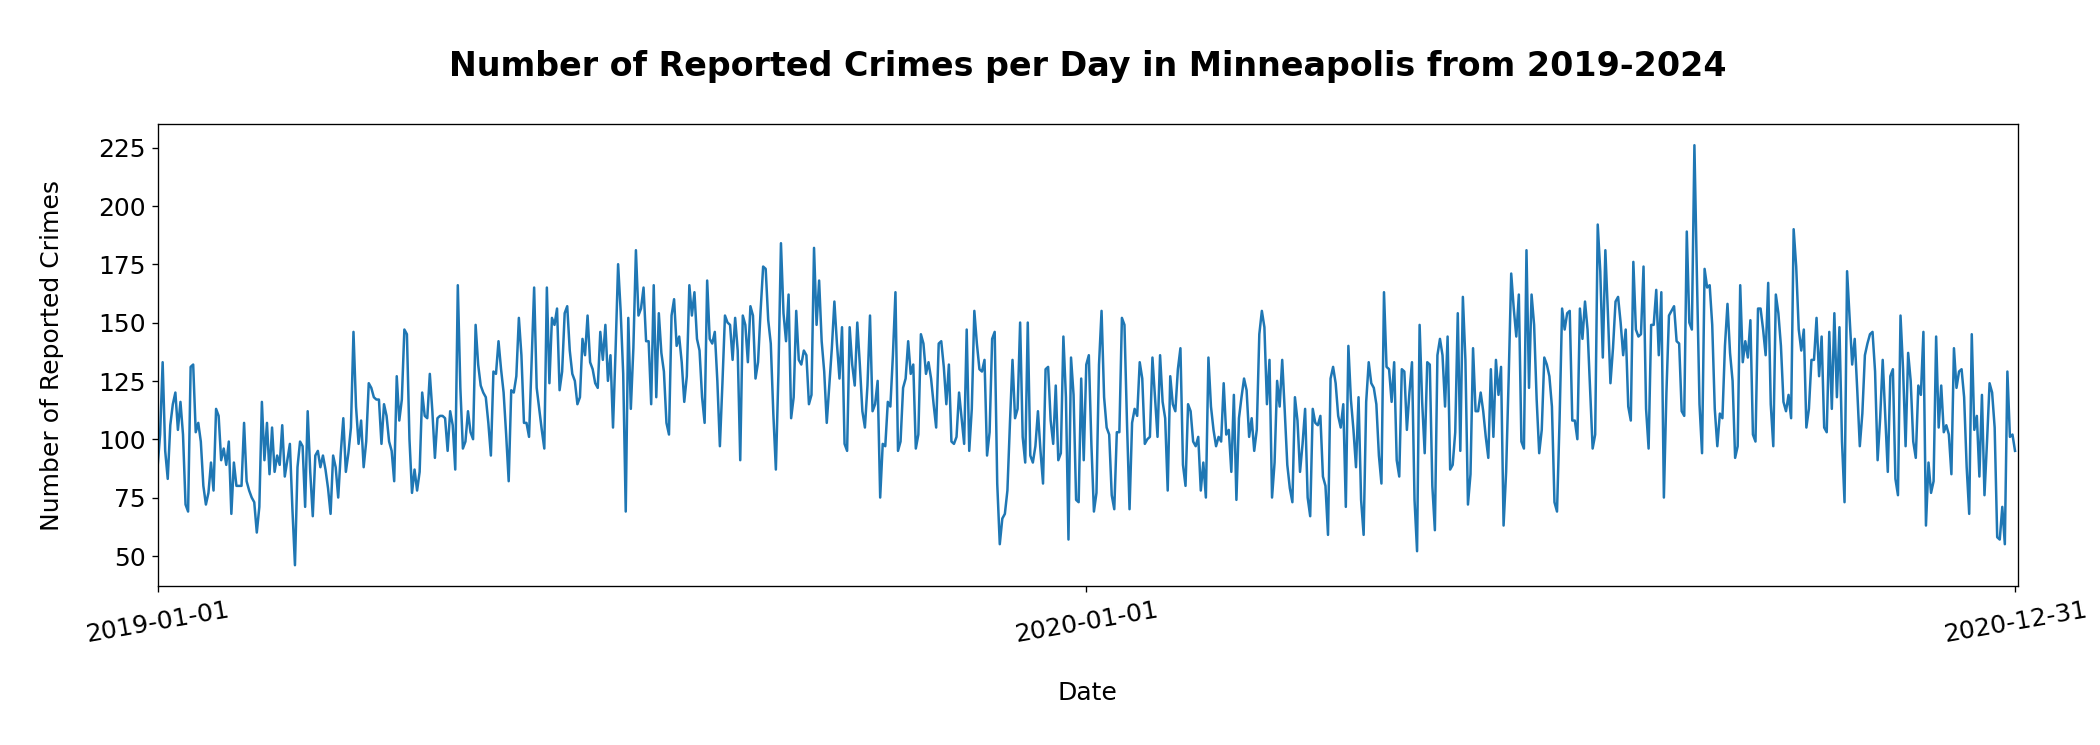

In [974]:
#Look at plot
fig, ax=plt.subplots(figsize=(20, 5))
plt.plot(train1.Crime_Count); 
plt.xticks(rotation=10, fontsize=15)

years = mdates.YearLocator()  
ax.xaxis.set_major_locator(years)

ax.set_xlim('2019-01-01', '2024-12-31')
ax.set_title("\nNumber of Reported Crimes per Day in Minneapolis from 2019-2024\n",weight='bold',fontdict={'fontsize':20})
ax.set_xlabel("\nDate\n",fontdict={'fontsize':15})
ax.set_ylabel("\nNumber of Reported Crimes\n",fontdict={'fontsize':15})



In [975]:
#ADF Test
from statsmodels.tsa.stattools import adfuller,kpss
# Perform Augmented Dickey-Fuller test
result = adfuller(train1)

# Extract and print the test statistics and p-value
test_statistic = result[0]
p_value = result[1]
print(f"Test Statistic: {test_statistic}")
print(f"P-value: {p_value}")

Test Statistic: -1.5447958387885525
P-value: 0.5112466837476183


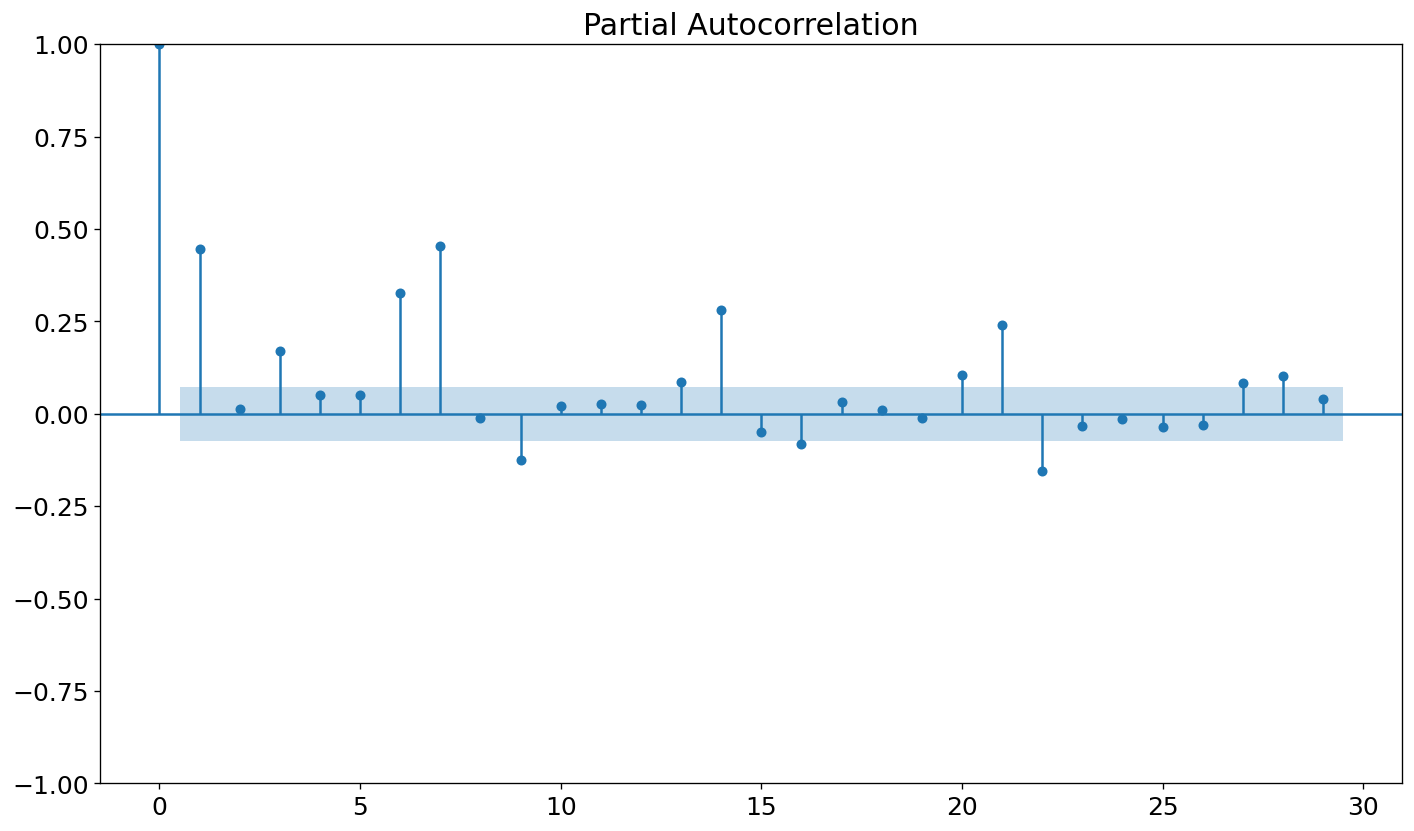

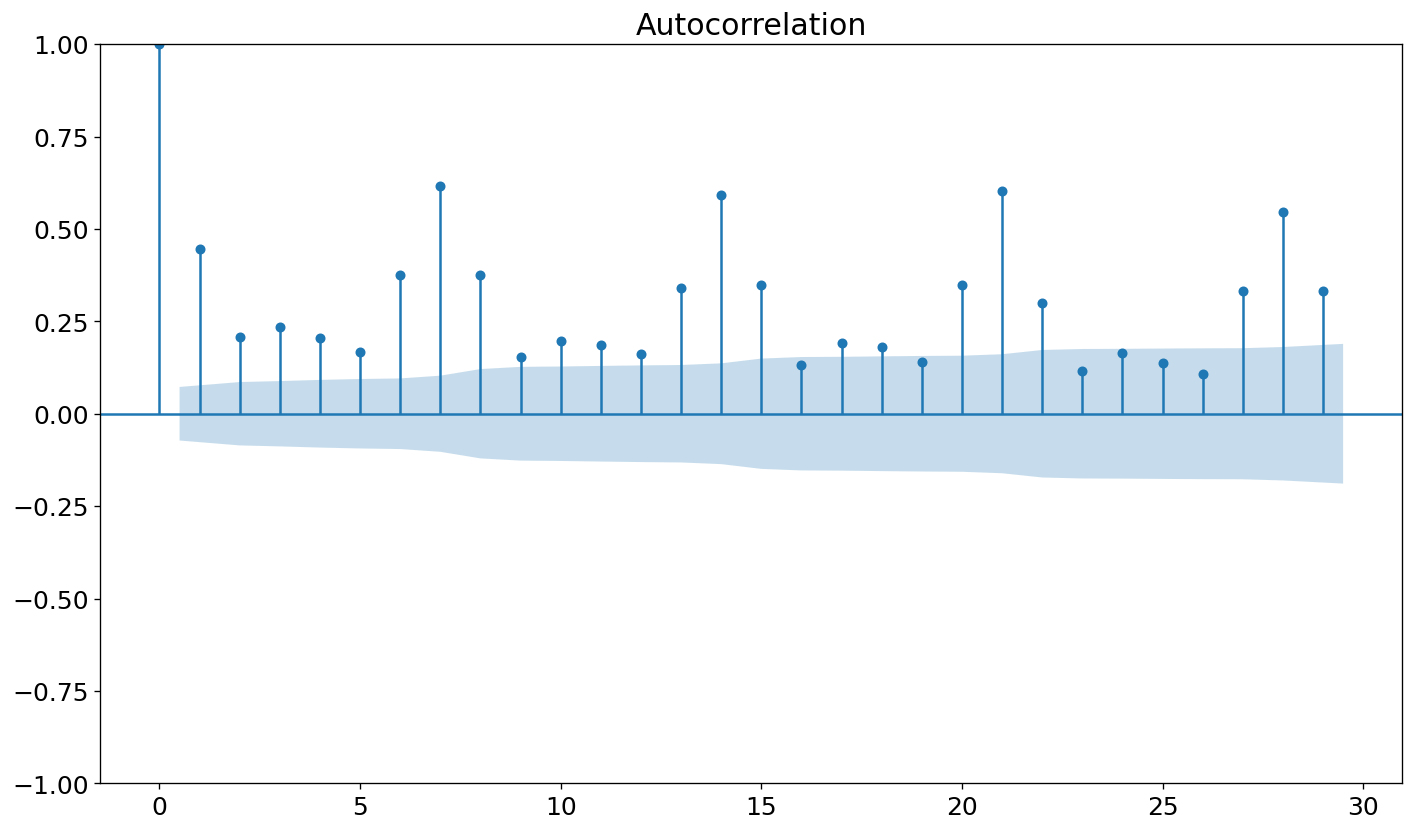

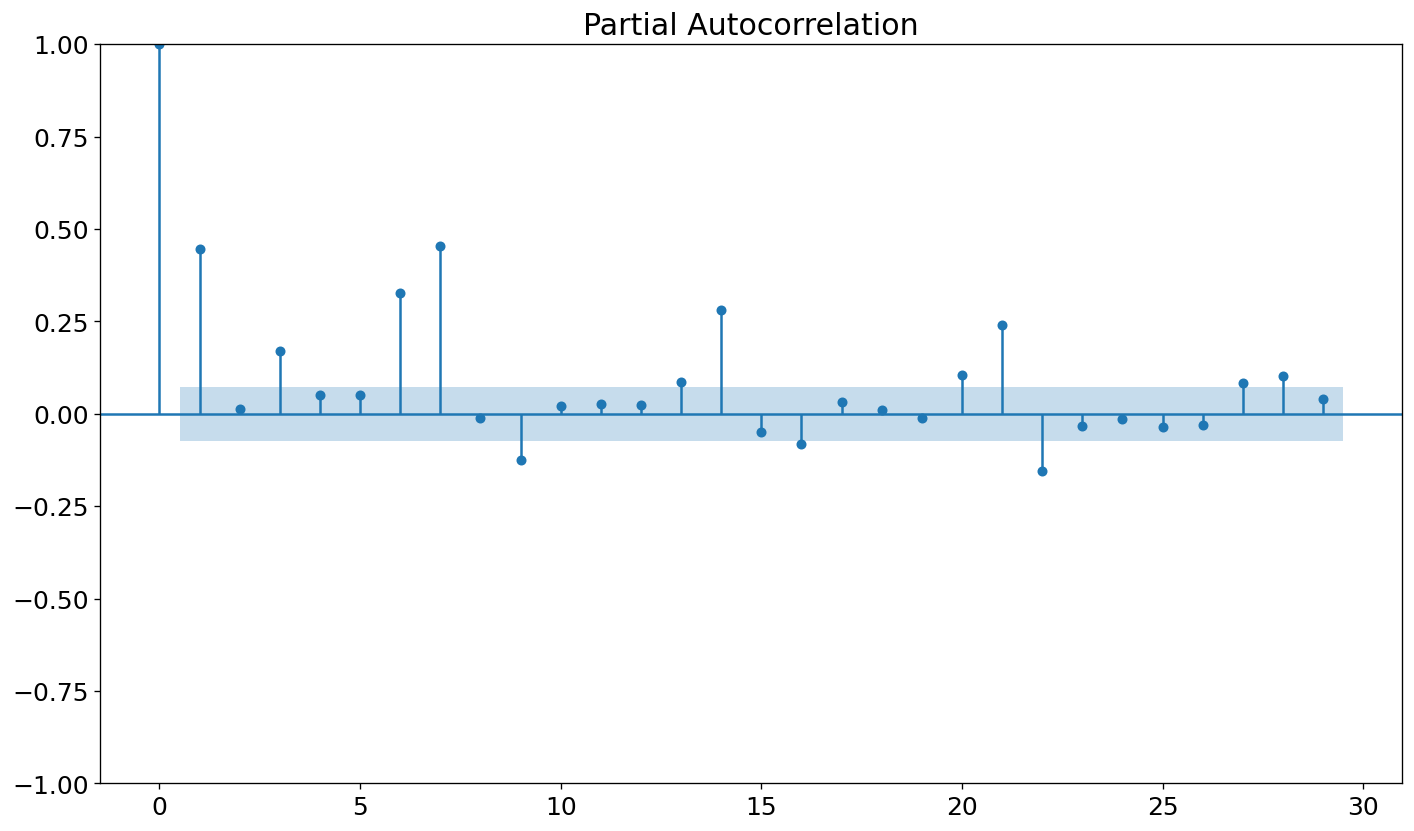

In [976]:
#ACF
plot_acf(train1.Crime_Count.dropna())
#PACF
plot_pacf(train1.Crime_Count.dropna())

### Check for Seasonality

In [977]:
train1['date']=train1.index
train1['date'] = pd.to_datetime(train1['date'], format='%Y-%m-%d')
train1

,Crime_Count,date
Date,,
2019-01-01,88,2019-01-01
2019-01-02,102,2019-01-02
2019-01-03,133,2019-01-03
2019-01-04,95,2019-01-04
2019-01-05,83,2019-01-05
...,...,...
2020-12-27,55,2020-12-27
2020-12-28,129,2020-12-28
2020-12-29,101,2020-12-29


<Axes: xlabel='Lag', ylabel='Autocorrelation'>

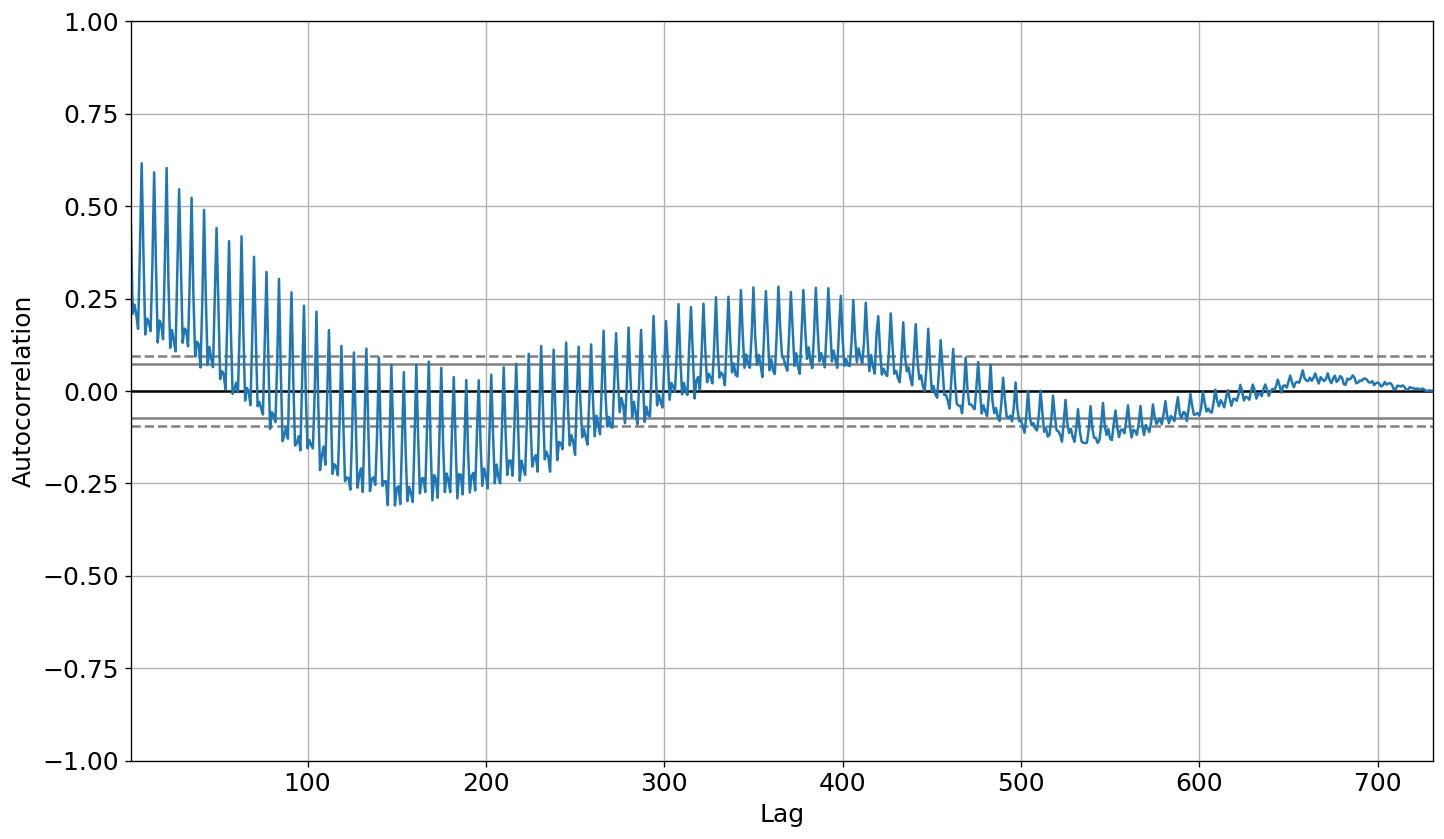

In [978]:
#Autocorrelation
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(train1['Crime_Count'])

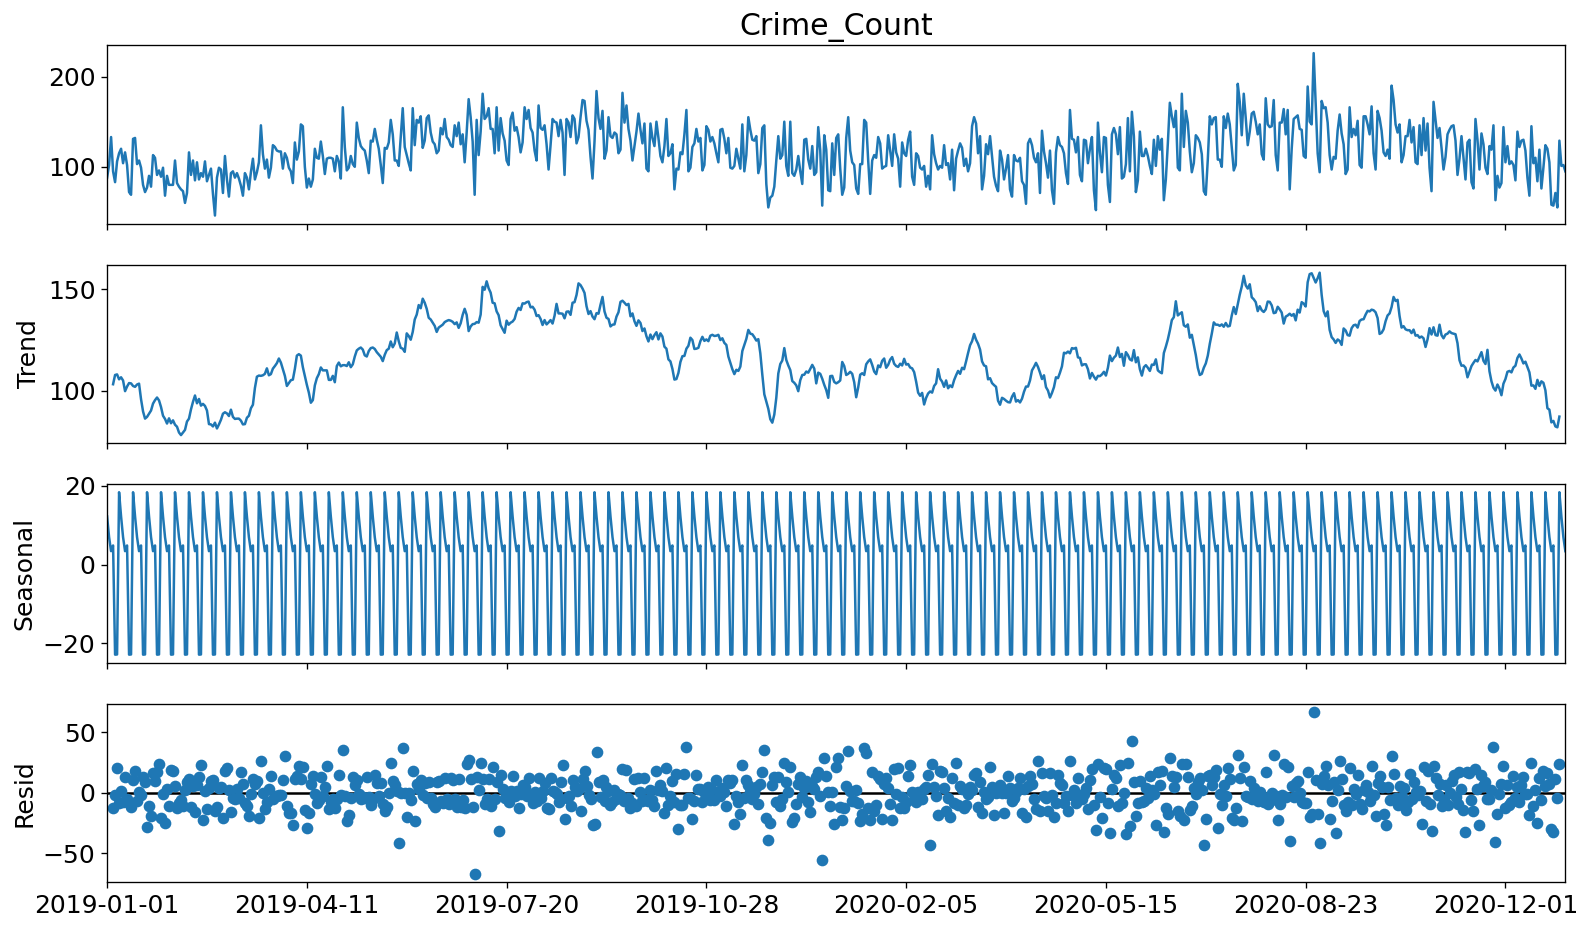

In [979]:
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition=seasonal_decompose(train1['Crime_Count'],model='additive',period=7)
decomposition.plot()
plt.xticks(ticks=range(0, len(train1), 100))
plt.show()

### Seasonal Differencing

In [1005]:
train1s1= train1
train1s1['Crime_Count']=train1.Crime_Count.diff(periods=7)
train1s1=train1s1.dropna()
train1s1

,Crime_Count,date
Date,,
2019-01-09,-30.0,2019-01-09
2019-01-10,-19.0,2019-01-10
2019-01-11,24.0,2019-01-11
2019-01-12,-18.0,2019-01-12
2019-01-13,-26.0,2019-01-13
...,...,...
2020-12-27,-39.0,2020-12-27
2020-12-28,49.0,2020-12-28
2020-12-29,-24.0,2020-12-29


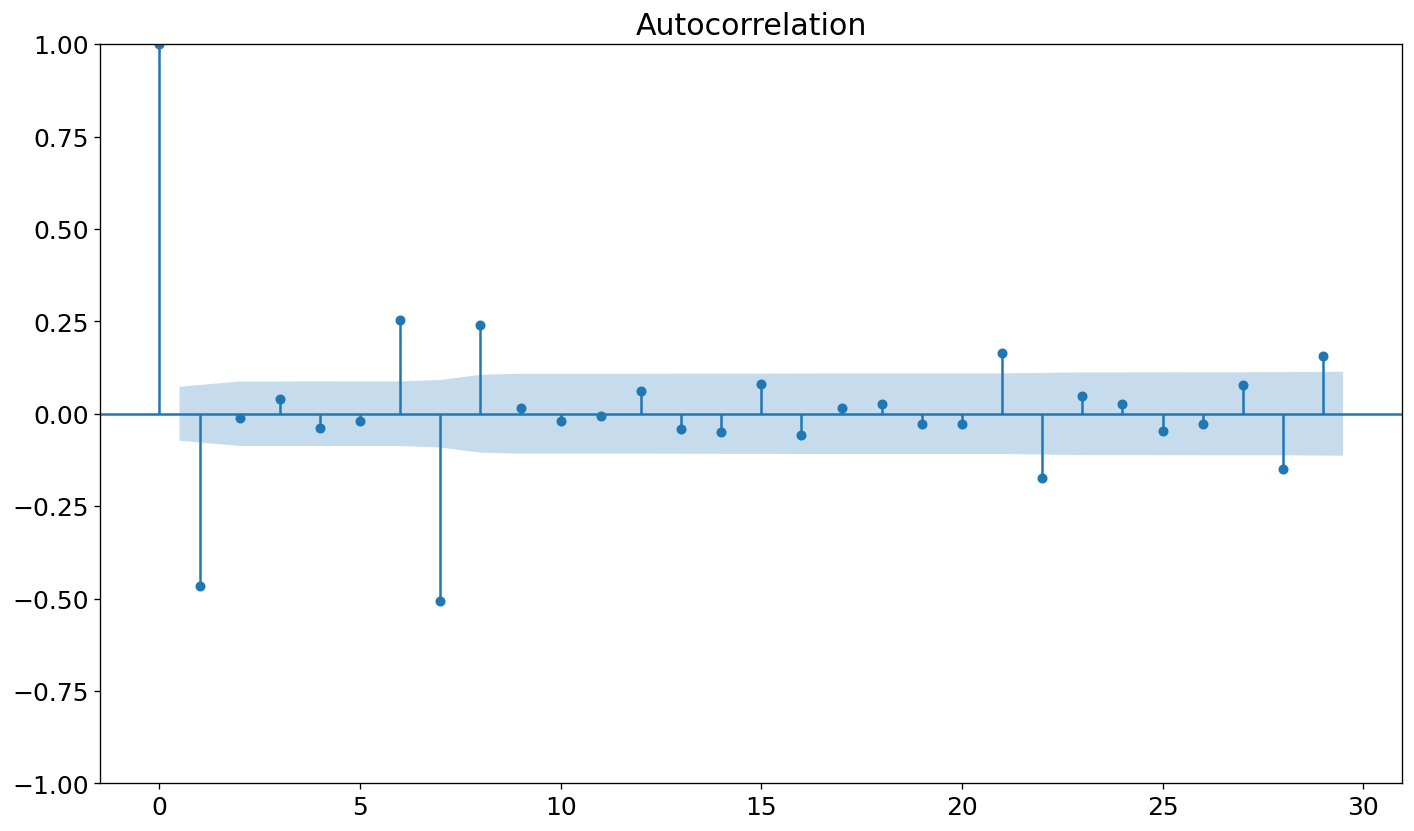

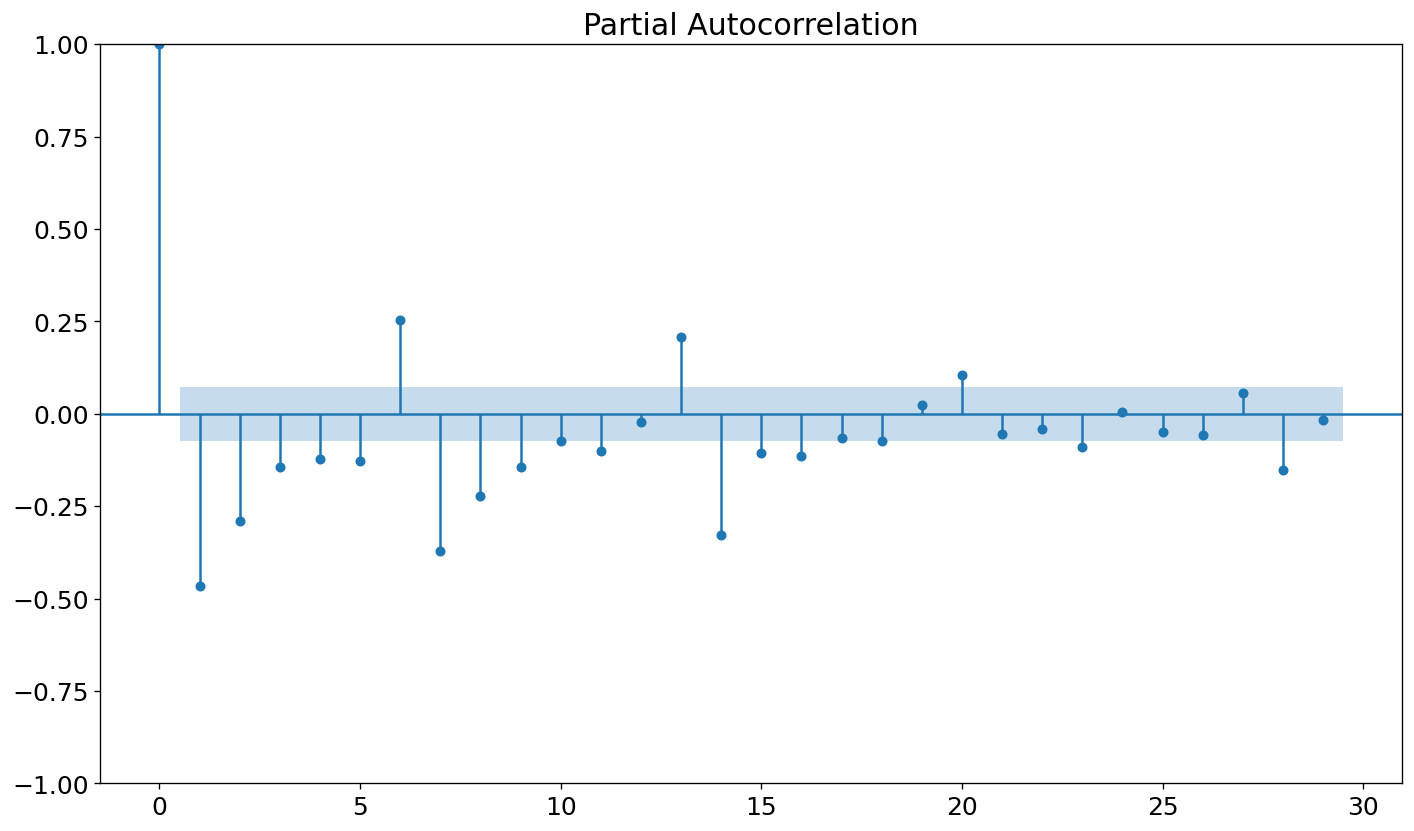

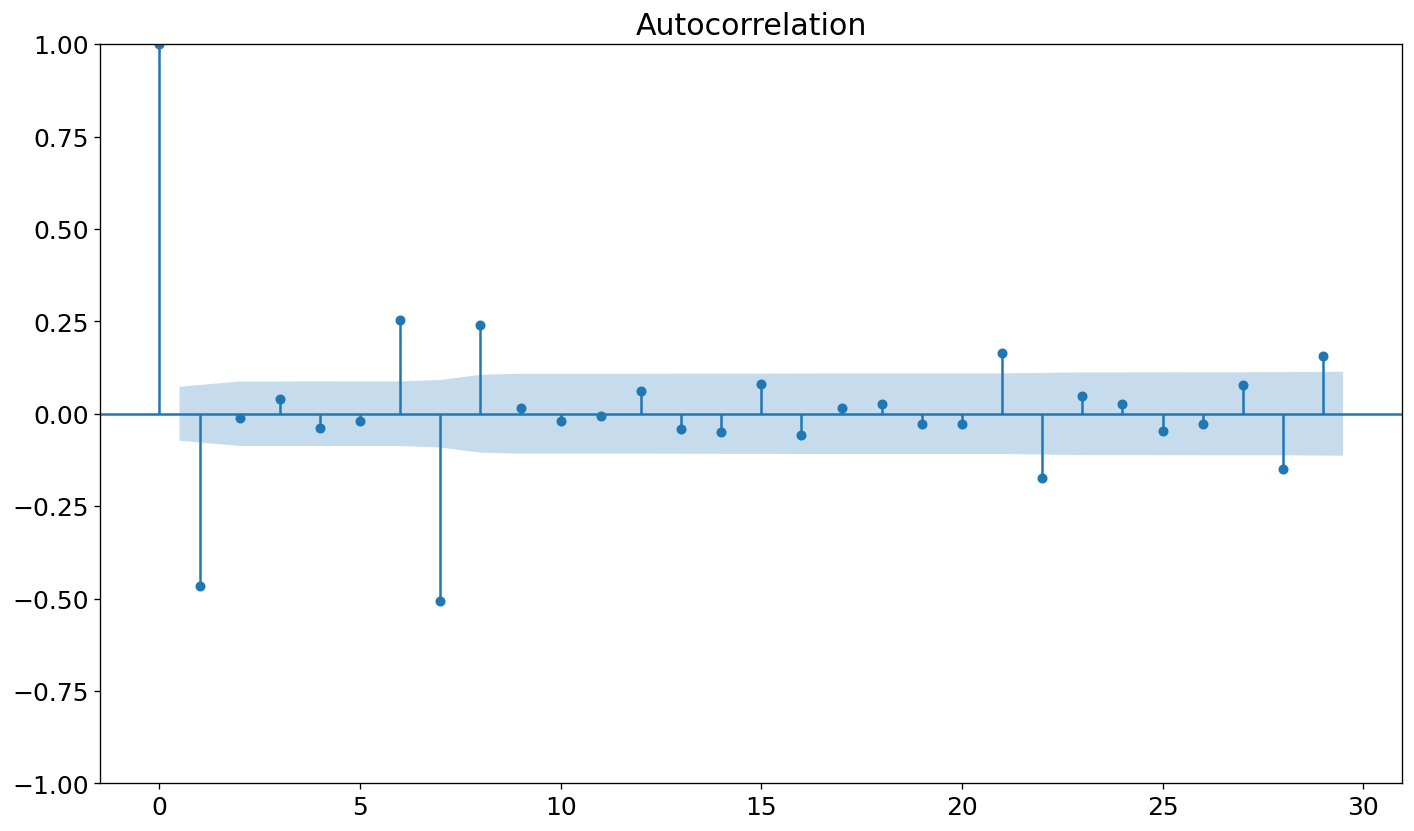

In [1006]:
plot_pacf(train1s1.Crime_Count)
plot_acf(train1s1.Crime_Count)

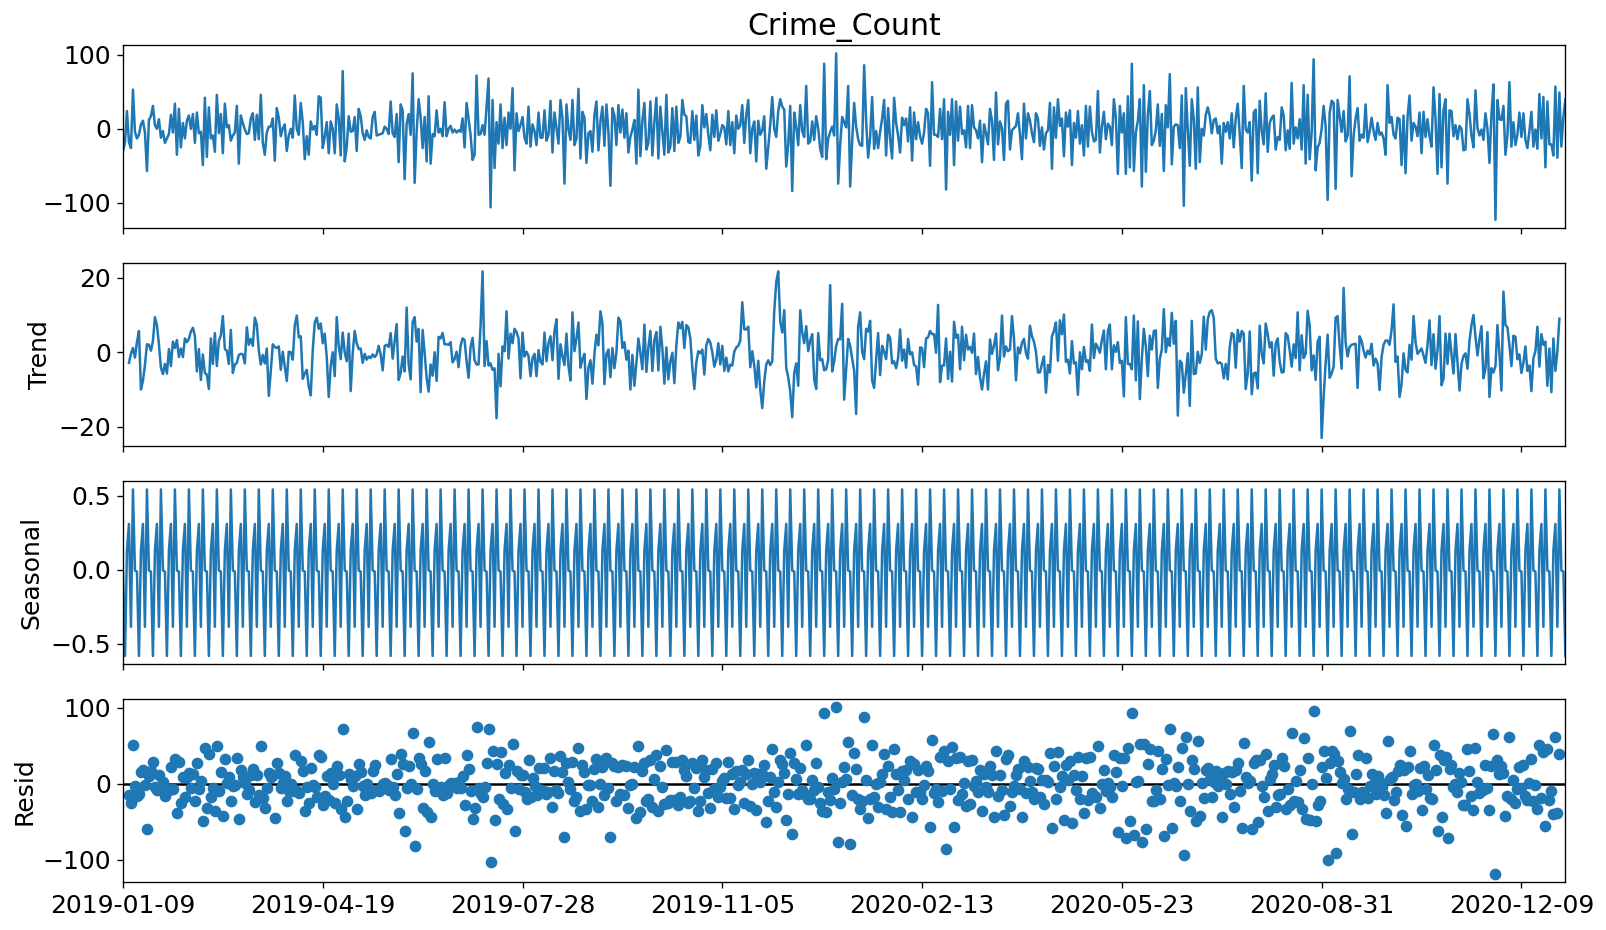

In [1008]:
# Trying Differencing of 7
decomposition=seasonal_decompose(train1s1['Crime_Count'],model='additive',period=7)
decomposition.plot()
plt.xticks(ticks=range(0, len(train1), 100))
plt.show()

In [1010]:
#ADF Test
from statsmodels.tsa.stattools import adfuller,kpss
# Perform Augmented Dickey-Fuller test
result = adfuller(train1s1['Crime_Count'])

# Extract and print the test statistics and p-value
test_statistic = result[0]
p_value = result[1]
print(f"Test Statistic: {test_statistic}")
print(f"P-value: {p_value}")

Test Statistic: -9.810953000232937
P-value: 5.659064863314911e-17


### Differencing to Remove Trend

In [990]:
# train1d3= train1d2
# train1d3['Crime_Count']=train1d2.Crime_Count.diff().dropna()
# train1d3

In [991]:
# Trying Differencing of 3
# plt.close()
# fig, ax=plt.subplots(figsize=(20, 5))
# plt.plot(train1d3.Crime_Count); 
# plt.xticks(rotation=10, fontsize=15)

# years = mdates.YearLocator()  
# ax.xaxis.set_major_locator(years)

# ax.set_xlim('2019-01-01', '2024-12-31')
# ax.set_title("\nNumber of Reported Crimes per Day in Minneapolis from 2019-2024\n",weight='bold',fontdict={'fontsize':20})
# ax.set_xlabel("\nDate\n",fontdict={'fontsize':15})
# ax.set_ylabel("\nNumber of Reported Crimes\n",fontdict={'fontsize':15})

In [992]:
# plot_pacf(train1d3.Crime_Count.dropna())
# plot_acf(train1d3.Crime_Count.dropna())

### Determine p and q

In [993]:
# #ACF
# plot_acf(train1.Crime_Count.dropna())
# #PACF
# plot_pacf(train1.Crime_Count.dropna())

### Calculate test MSE

In [994]:
#test MSE1

## STEP 2: Set 2 2019-2022
### Check Stationarity

In [995]:
# #Look at plot
# ax.clear()
# fig, ax=plt.subplots(figsize=(20, 5))
# plt.plot(train2.Crime_Count); 
# plt.xticks(rotation=10, fontsize=15)

# years = mdates.YearLocator()  
# ax.xaxis.set_major_locator(years)

# ax.set_xlim('2019-01-01', '2024-12-31')
# ax.set_title("\nNumber of Reported Crimes per Day in Minneapolis from 2019-2024\n",weight='bold',fontdict={'fontsize':20})
# ax.set_xlabel("\nDate\n",fontdict={'fontsize':15})
# ax.set_ylabel("\nNumber of Reported Crimes\n",fontdict={'fontsize':15})



In [996]:
#ADF Test

### Differencing

### Determine p and q

In [997]:
#ACF
#plot_acf(train_set.Crime_Count)
#PACF
#plot_pacf(train_set.Crime_Count,lags=30)

### Calculate test MSE

## STEP 2: Set 2 2019-2023
### Check Stationarity

In [998]:
# #Look at plot
# fig, ax=plt.subplots(figsize=(20, 5))
# plt.plot(train_set.Crime_Count); 
# plt.xticks(rotation=10, fontsize=15)

# years = mdates.YearLocator()  
# ax.xaxis.set_major_locator(years)

# ax.set_xlim('2019-01-01', '2024-12-31')
# ax.set_title("\nNumber of Reported Crimes per Day in Minneapolis from 2019-2024\n",weight='bold',fontdict={'fontsize':20})
# ax.set_xlabel("\nDate\n",fontdict={'fontsize':15})
# ax.set_ylabel("\nNumber of Reported Crimes\n",fontdict={'fontsize':15})



### Fit ARIMA Model and compare to AutoARIMA

In [999]:
#ARIMA Model

In [1000]:
#Auto ARIMA Model

### Calculate test MSE

In [1001]:
#calculate test MSE

### K-Folds? Approach using all-subset selection

### Fit ARIMA Model and compare to AutoARIMA

In [1002]:
# ##AutoARIMA

# #split into 6-folds
# tscv = TimeSeriesSplit(n_splits=6)

# # Initialize lists to store evaluation metrics
# mse_scores = []

# # Iterate over train-test splits and train models
# for train_index, test_index in tscv.split(unidf):
#     train_data, test_data = unidf.iloc[train_index], unidf.iloc[test_index]

#     # Fit ARIMA model
#     model = ARIMA(train_data, )  # Example order for ARIMA
#     fitted_model = model.fit()

#     # Make predictions
#     predictions = fitted_model.forecast(steps=len(test_data))

#     # Calculate Mean Squared Error
#     mse = mean_squared_error(test_data, predictions)
#     mse_scores.append(mse)

#     print(f'Mean Squared Error for current split: {mse}')

# # Calculate average Mean Squared Error across all splits
# average_mse = np.mean(mse_scores)
# print(f'Average Mean Squared Error across all splits: {average_mse}')

### Fit Best Model and Forecast

In [1003]:
#Fit Best Model

In [1004]:
#Forecast 2025

## Random Forests Time Series Regression
1. Lagged predictors
2. Check Assumptions and make corrections if needed
3. Select ARIMA Model
4. Select Best ARIMA Model
4. Interpret